### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Connect to Google Drive

In [1]:
# # Import libraries for importing files from Google drive to Colab
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authorize Google SDK to access Google Drive from Colab

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [2]:
# download = drive.CreateFile({'id': '請自行輸入自己上傳google drive檔案的連結id'})
# download.GetContentFile('ptb.train.txt')

### Import Necessary Libraries

In [3]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
# 讀取資料

# Penn Tree Back dataset
with open("./ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [5]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [6]:
# 定義資料前處理函示
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
        
            # hint: 請計算字詞頻率
            counter.update(sentence)
            processed_sentence.append(sentence)
    
        # hint: 移除頻率過小的字詞 建立word2idx與idx2word與word_frequency辭典
        word_cnt = dict(filter(lambda x:x[1]>self.min_freq, counter.items()))
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys())}
        self.idx2word ={idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if not self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            self.word_frequency = dict(counter.items())
            print(f"After subsampling: {self.total_num_words} words")
        
        # hint: 移除空字串
        self.processed_corpus = [line for line in self.processed_corpus if len(line) != 0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words

    def subsampling(self, idx):
        
        # hint: 學員可以參考講義的subsampling公式(也可自己定義一個)
        
        p = self.t / self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt(p) + p
        return random.uniform(0, 1) < p_w


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 885720 words
After subsampling: 449166 words


### 定義Skip-gram使用的Dataset與collate function

In [7]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx])
        
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2 * self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建上下文(考慮window_size)
            all_contexts += line[self.window_size:-self.window_size]

            targets = []
            for idx in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標字詞
                indices = list(range(idx - self.window_size, idx + self.window_size + 1))
                indices.remove(idx)
                all_targets.append([line[i] for i in indices])

        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word] ** 0.75 for word in self.word2freq]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        for targets in self.all_targets:
            negatives = []
            while len(negatives) < self.num_negatives:
                neg_candidate = random.choices(population, sampling_weights)[0]
                neg_cnadidate = self.word2idx[cur_exists_words[neg_candidate]]
                if neg_candidate not in targets:
                    negatives.append(neg_candidate)
            all_negatives.append(negatives)
        
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
        target_negative += [target + negative]
        labels += [[1] * len(target) + [0] * len(negative)]
        contexts += [context]
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

### 定義Skip-gram模型

In [8]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = self.in_embedding(contexts)
        u = self.out_embedding(targets)
        
        # do dot product to get output
        pred = torch.matmul(v.unsqueeze(1), u.permute(0,2,1))
        
        return pred.squeeze(dim=1)

### 訓練

In [9]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 20
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, 1, 5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=skipgram_collate)

In [10]:
# Start training

lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        
        optimizer.zero_grad()
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
            
        pred = model(contexts, target_negative)
        loss = criterion(pred, labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Batch: 501/715.779296875 Loss: 0.67847


  5%|▌         | 1/20 [00:22<07:10, 22.67s/it]

Epoch: 1/20, Loss: 0.55976
Epoch: 2/20, Batch: 501/715.779296875 Loss: 0.25218


 10%|█         | 2/20 [00:48<07:05, 23.62s/it]

Epoch: 2/20, Loss: 0.24999
Epoch: 3/20, Batch: 501/715.779296875 Loss: 0.23675


 15%|█▌        | 3/20 [01:11<06:36, 23.31s/it]

Epoch: 3/20, Loss: 0.23696
Epoch: 4/20, Batch: 501/715.779296875 Loss: 0.23192


 20%|██        | 4/20 [01:38<06:31, 24.50s/it]

Epoch: 4/20, Loss: 0.23231
Epoch: 5/20, Batch: 501/715.779296875 Loss: 0.22895


 25%|██▌       | 5/20 [02:02<06:07, 24.47s/it]

Epoch: 5/20, Loss: 0.22962
Epoch: 6/20, Batch: 501/715.779296875 Loss: 0.22735


 30%|███       | 6/20 [02:28<05:48, 24.90s/it]

Epoch: 6/20, Loss: 0.22776
Epoch: 7/20, Batch: 501/715.779296875 Loss: 0.22633


 35%|███▌      | 7/20 [02:52<05:20, 24.62s/it]

Epoch: 7/20, Loss: 0.22638
Epoch: 8/20, Batch: 501/715.779296875 Loss: 0.22480


 40%|████      | 8/20 [03:16<04:53, 24.46s/it]

Epoch: 8/20, Loss: 0.22533
Epoch: 9/20, Batch: 501/715.779296875 Loss: 0.22423


 45%|████▌     | 9/20 [03:40<04:27, 24.31s/it]

Epoch: 9/20, Loss: 0.22473
Epoch: 10/20, Batch: 501/715.779296875 Loss: 0.22384


 50%|█████     | 10/20 [04:04<04:02, 24.20s/it]

Epoch: 10/20, Loss: 0.22413
Epoch: 11/20, Batch: 501/715.779296875 Loss: 0.22317


 55%|█████▌    | 11/20 [04:28<03:37, 24.18s/it]

Epoch: 11/20, Loss: 0.22367
Epoch: 12/20, Batch: 501/715.779296875 Loss: 0.22311


 60%|██████    | 12/20 [04:52<03:12, 24.09s/it]

Epoch: 12/20, Loss: 0.22354
Epoch: 13/20, Batch: 501/715.779296875 Loss: 0.22283


 65%|██████▌   | 13/20 [05:16<02:47, 23.97s/it]

Epoch: 13/20, Loss: 0.22330
Epoch: 14/20, Batch: 501/715.779296875 Loss: 0.22244


 70%|███████   | 14/20 [05:40<02:23, 24.00s/it]

Epoch: 14/20, Loss: 0.22316
Epoch: 15/20, Batch: 501/715.779296875 Loss: 0.22303


 75%|███████▌  | 15/20 [06:04<01:59, 23.96s/it]

Epoch: 15/20, Loss: 0.22308
Epoch: 16/20, Batch: 501/715.779296875 Loss: 0.22265


 80%|████████  | 16/20 [06:28<01:35, 23.99s/it]

Epoch: 16/20, Loss: 0.22293
Epoch: 17/20, Batch: 501/715.779296875 Loss: 0.22240


 85%|████████▌ | 17/20 [06:53<01:13, 24.49s/it]

Epoch: 17/20, Loss: 0.22290
Epoch: 18/20, Batch: 501/715.779296875 Loss: 0.22219


 90%|█████████ | 18/20 [07:18<00:48, 24.39s/it]

Epoch: 18/20, Loss: 0.22276
Epoch: 19/20, Batch: 501/715.779296875 Loss: 0.22182


 95%|█████████▌| 19/20 [07:42<00:24, 24.32s/it]

Epoch: 19/20, Loss: 0.22276
Epoch: 20/20, Batch: 501/715.779296875 Loss: 0.22224


100%|██████████| 20/20 [08:06<00:00, 24.33s/it]

Epoch: 20/20, Loss: 0.22271


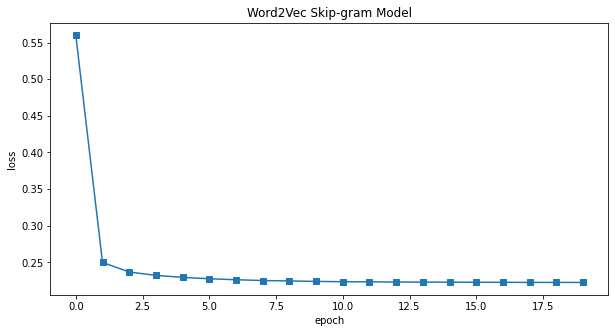

In [11]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [12]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.390: sleep.
cosine sim=0.374: players.
cosine sim=0.348: consultants.
cosine sim=0.342: ideological.
